In [2]:
!unzip -q /content/put.zip -d /content/output

Found 430 frame images, 234 mask images, 342 diff images
Matched samples: 137
Sample match - Stem: sangjuyeongcheonseonyeongcheonbungijeom20250330135115
  Frame: [sangjuyeongcheonseon]_yeongcheonbungijeom_2025-03-30_13-51-15_frame.png
  Mask: [sangjuyeongcheonseon_yeongcheonbungijeom]__2025-03-30_13-51-15_mask.png
  Diff: [sangjuyeongcheonseon]_yeongcheonbungijeom_2025-03-30_13-51-15_diff.png
Dataset: 137.
Train: 95장, Val: 20장, Test: 22장


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/273 [00:00<?, ?B/s]

/usr/local/lib/python3.11/dist-packages/transformers/models/segformer/feature_extraction_segformer.py:28: FutureWarning: The class SegformerFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use SegformerImageProcessor instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/transformers/utils/deprecation.py:172: UserWarning: The following named arguments are not valid for `SegformerFeatureExtractor.__init__` and were ignored: 'feature_extractor_type'
  return func(*args, **kwargs)


config.json:   0%|          | 0.00/1.68k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/54.8M [00:00<?, ?B/s]

Training model without Diff...
Without Diff - Epoch 1/10, Train Loss: 0.7067, Val Loss: 0.5702
Without Diff - Epoch 2/10, Train Loss: 0.5367, Val Loss: 0.4350
Without Diff - Epoch 3/10, Train Loss: 0.3922, Val Loss: 0.3256
Without Diff - Epoch 4/10, Train Loss: 0.2900, Val Loss: 0.2378
Without Diff - Epoch 5/10, Train Loss: 0.2239, Val Loss: 0.2089
Without Diff - Epoch 6/10, Train Loss: 0.1802, Val Loss: 0.1566
Without Diff - Epoch 7/10, Train Loss: 0.1549, Val Loss: 0.1363
Without Diff - Epoch 8/10, Train Loss: 0.1359, Val Loss: 0.1309
Without Diff - Epoch 9/10, Train Loss: 0.1217, Val Loss: 0.1125
Without Diff - Epoch 10/10, Train Loss: 0.1124, Val Loss: 0.0960

Training model with Diff...
With Diff - Epoch 1/10, Train Loss: 0.7686, Val Loss: 0.6909
With Diff - Epoch 2/10, Train Loss: 0.5880, Val Loss: 0.5076
With Diff - Epoch 3/10, Train Loss: 0.4407, Val Loss: 0.3669
With Diff - Epoch 4/10, Train Loss: 0.3312, Val Loss: 0.2723
With Diff - Epoch 5/10, Train Loss: 0.2539, Val Loss: 0

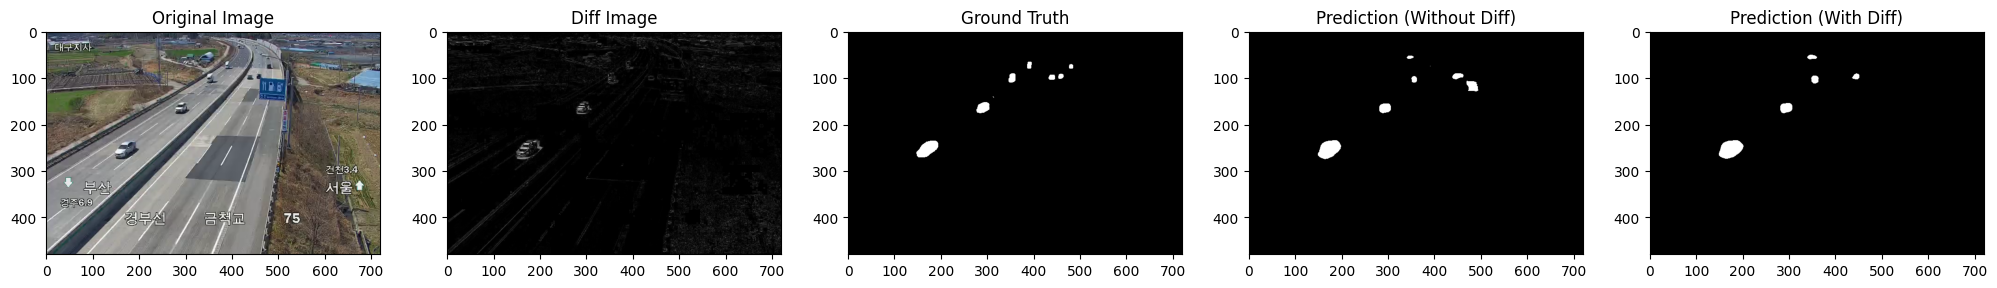

In [3]:
# 1.
!pip install transformers torch torchvision opencv-python numpy scikit-learn matplotlib

# 2.
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from transformers import SegformerFeatureExtractor, SegformerForSemanticSegmentation
from sklearn.metrics import jaccard_score, accuracy_score, precision_score, recall_score, f1_score
import matplotlib.pyplot as plt
from PIL import Image
import random
import re

# 3. 데이터셋 경로 설정 / Dataset Path

images_dir = '/content/output/frames'  # frame
masks_dir = '/content/output/masks'    # mask
diffs_dir = '/content/output/diffs'    # diff

# 4. frame mask diff matching
def get_matched_triplets_by_stem(images_dir, masks_dir, diffs_dir):
    def normalize_filename(filename):
        return re.sub(r'[^a-zA-Z0-9]', '', filename)

    def get_stem(filename, suffix):
        if filename.endswith(suffix):
            return normalize_filename(filename.replace(suffix, ""))
        return None

    image_files = [f for f in os.listdir(images_dir) if f.endswith("_frame.png")]
    mask_files = [f for f in os.listdir(masks_dir) if f.endswith("_mask.png")]
    diff_files = [f for f in os.listdir(diffs_dir) if f.endswith("_diff.png")]

    print(f"Found {len(image_files)} frame images, {len(mask_files)} mask images, {len(diff_files)} diff images")

    image_stems = {get_stem(f, "_frame.png"): f for f in image_files if get_stem(f, "_frame.png") is not None}
    mask_stems = {get_stem(f, "_mask.png"): f for f in mask_files if get_stem(f, "_mask.png") is not None}
    diff_stems = {get_stem(f, "_diff.png"): f for f in diff_files if get_stem(f, "_diff.png") is not None}

    common_stems = set(image_stems.keys()) & set(mask_stems.keys()) & set(diff_stems.keys())

    image_paths = [os.path.join(images_dir, image_stems[stem]) for stem in common_stems]
    mask_paths = [os.path.join(masks_dir, mask_stems[stem]) for stem in common_stems]
    diff_paths = [os.path.join(diffs_dir, diff_stems[stem]) for stem in common_stems]

    print(f"Matched samples: {len(common_stems)}")
    if common_stems:
        sample_stem = list(common_stems)[0]
        print(f"Sample match - Stem: {sample_stem}")
        print(f"  Frame: {image_stems[sample_stem]}")
        print(f"  Mask: {mask_stems[sample_stem]}")
        print(f"  Diff: {diff_stems[sample_stem]}")

    return image_paths, mask_paths, diff_paths

# 5. Dataset Load
image_paths, mask_paths, diff_paths = get_matched_triplets_by_stem(images_dir, masks_dir, diffs_dir)
print(f"Dataset: {len(image_paths)}.")

# 6. Custom Dataset Class
class SegmentationDataset(Dataset):
    def __init__(self, image_paths, mask_paths, diff_paths, feature_extractor, use_diff=False, alpha=0.5):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.diff_paths = diff_paths
        self.feature_extractor = feature_extractor
        self.use_diff = use_diff
        self.alpha = alpha

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")
        mask = Image.open(self.mask_paths[idx]).convert("L")  # Grayscale

        # mask to binary (vehicle: 1, background: 0)
        mask = np.array(mask)
        mask = (mask > 0).astype(np.int64)

        # Using Diff
        if self.use_diff:
            diff = Image.open(self.diff_paths[idx]).convert("L")
            diff = np.array(diff) / 255.0
            image_np = np.array(image).astype(np.float32)
            image_np += self.alpha * diff[..., np.newaxis] * 255.0
            image_np = np.clip(image_np, 0, 255).astype(np.uint8)
            image = Image.fromarray(image_np)

        # SegFormer
        inputs = self.feature_extractor(images=image, segmentation_maps=mask, return_tensors="pt")
        pixel_values = inputs['pixel_values'].squeeze(0)
        labels = inputs['labels'].squeeze(0)

        return pixel_values, labels

# 7. Dataset (70:15:15)
dataset_size = len(image_paths)
train_size = int(0.7 * dataset_size)
val_size = int(0.15 * dataset_size)
test_size = dataset_size - train_size - val_size

print(f"Train: {train_size}장, Val: {val_size}장, Test: {test_size}장")

# Seed Random
random.seed(42)
torch.manual_seed(42)

# (With Diff/Without Diff)
feature_extractor = SegformerFeatureExtractor.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
dataset_without_diff = SegmentationDataset(image_paths, mask_paths, diff_paths, feature_extractor, use_diff=False)
dataset_with_diff = SegmentationDataset(image_paths, mask_paths, diff_paths, feature_extractor, use_diff=True, alpha=0.5)

#
train_dataset_without, val_dataset_without, test_dataset_without = random_split(dataset_without_diff, [train_size, val_size, test_size])
#
train_dataset_with, val_dataset_with, test_dataset_with = random_split(dataset_with_diff, [train_size, val_size, test_size])

batch_size = 4  # You have to set for your GPU
# Without Diff Dataloader
train_loader_without = DataLoader(train_dataset_without, batch_size=batch_size, shuffle=True)
val_loader_without = DataLoader(val_dataset_without, batch_size=batch_size, shuffle=False)
test_loader_without = DataLoader(test_dataset_without, batch_size=batch_size, shuffle=False)
# With Diff DataLoader
train_loader_with = DataLoader(train_dataset_with, batch_size=batch_size, shuffle=True)
val_loader_with = DataLoader(val_dataset_with, batch_size=batch_size, shuffle=False)
test_loader_with = DataLoader(test_dataset_with, batch_size=batch_size, shuffle=False)

# 8. Model / Diff or not
model_without_diff = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
model_without_diff.config.num_labels = 2  #
model_without_diff.decode_head.classifier = torch.nn.Conv2d(256, 2, kernel_size=1)

model_with_diff = SegformerForSemanticSegmentation.from_pretrained("nvidia/segformer-b1-finetuned-cityscapes-1024-1024")
model_with_diff.config.num_labels = 2
model_with_diff.decode_head.classifier = torch.nn.Conv2d(256, 2, kernel_size=1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_without_diff.to(device)
model_with_diff.to(device)

# 9. Train Set
optimizer_without = torch.optim.AdamW(model_without_diff.parameters(), lr=5e-5)
optimizer_with = torch.optim.AdamW(model_with_diff.parameters(), lr=5e-5)
num_epochs = 10  # EPOCH

# 10.
def train_model(model, train_loader, val_loader, optimizer, num_epochs, model_name):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for pixel_values, labels in train_loader:
            pixel_values = pixel_values.to(device)
            labels = labels.to(device)
            outputs = model(pixel_values=pixel_values, labels=labels)
            loss = outputs.loss
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            train_loss += loss.item()

        # VAL
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for pixel_values, labels in val_loader:
                pixel_values = pixel_values.to(device)
                labels = labels.to(device)
                outputs = model(pixel_values=pixel_values, labels=labels)
                val_loss += outputs.loss.item()

        print(f"{model_name} - Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss/len(train_loader):.4f}, Val Loss: {val_loss/len(val_loader):.4f}")

# 11. Launch for Train
print("Training model without Diff...")
train_model(model_without_diff, train_loader_without, val_loader_without, optimizer_without, num_epochs, "Without Diff")
print("\nTraining model with Diff...")
train_model(model_with_diff, train_loader_with, val_loader_with, optimizer_with, num_epochs, "With Diff")

# 12. EVAL
def evaluate_model(model, test_loader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for pixel_values, labels in test_loader:
            pixel_values = pixel_values.to(device)
            outputs = model(pixel_values=pixel_values)
            logits = outputs.logits
            upsampled_logits = torch.nn.functional.interpolate(logits, size=labels.shape[-2:], mode='bilinear', align_corners=False)
            predicted = upsampled_logits.argmax(dim=1).cpu().numpy()
            all_preds.append(predicted.flatten())
            all_labels.append(labels.numpy().flatten())

    all_preds = np.concatenate(all_preds)
    all_labels = np.concatenate(all_labels)

    # Evaluation reference
    metrics = {
        'IoU': jaccard_score(all_labels, all_preds, average='binary'),
        'Accuracy': accuracy_score(all_labels, all_preds),
        'Precision': precision_score(all_labels, all_preds, average='binary'),
        'Recall': recall_score(all_labels, all_preds, average='binary'),
        'F1': f1_score(all_labels, all_preds, average='binary')
    }
    return metrics

# 13. result
print("\nEvaluating model without Diff...")
metrics_without = evaluate_model(model_without_diff, test_loader_without)
print("Without Diff Metrics:")
for key, value in metrics_without.items():
    print(f"{key}: {value:.4f}")

print("\nEvaluating model with Diff...")
metrics_with = evaluate_model(model_with_diff, test_loader_with)
print("With Diff Metrics:")
for key, value in metrics_with.items():
    print(f"{key}: {value:.4f}")

# 14. compare
print("\nComparison:")
for key in metrics_without.keys():
    diff = metrics_with[key] - metrics_without[key]
    print(f"{key} Difference (With Diff - Without Diff): {diff:.4f}")

# 15. Visualization
def visualize_prediction(image_path, mask_path, diff_path, model_without, model_with, feature_extractor):
    image = Image.open(image_path).convert("RGB")
    mask_gt = np.array(Image.open(mask_path).convert("L")) > 0  # Ground Truth
    diff = np.array(Image.open(diff_path).convert("L")) / 255.0

    # Diff WITHOUT
    inputs = feature_extractor(images=image, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    with torch.no_grad():
        outputs = model_without(pixel_values=pixel_values)
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    predicted_mask_without = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy() == 1

    # Diff WITH
    image_np = np.array(image).astype(np.float32)
    image_np += 0.5 * diff[..., np.newaxis] * 255.0
    image_np = np.clip(image_np, 0, 255).astype(np.uint8)
    image_with_diff = Image.fromarray(image_np)
    inputs = feature_extractor(images=image_with_diff, return_tensors="pt")
    pixel_values = inputs['pixel_values'].to(device)
    with torch.no_grad():
        outputs = model_with(pixel_values=pixel_values)
    logits = outputs.logits
    upsampled_logits = torch.nn.functional.interpolate(logits, size=image.size[::-1], mode='bilinear', align_corners=False)
    predicted_mask_with = upsampled_logits.argmax(dim=1).squeeze().cpu().numpy() == 1

    # VISUALIZAITON
    fig, ax = plt.subplots(1, 5, figsize=(25, 5))
    ax[0].imshow(image); ax[0].set_title("Original Image")
    ax[1].imshow(diff, cmap='gray'); ax[1].set_title("Diff Image")
    ax[2].imshow(mask_gt, cmap='gray'); ax[2].set_title("Ground Truth")
    ax[3].imshow(predicted_mask_without, cmap='gray'); ax[3].set_title("Prediction (Without Diff)")
    ax[4].imshow(predicted_mask_with, cmap='gray'); ax[4].set_title("Prediction (With Diff)")
    plt.show()

# Random VIsualization
random_idx = random.randint(0, len(test_dataset_without) - 1)
image_path = test_dataset_without.dataset.image_paths[test_dataset_without.indices[random_idx]]
mask_path = test_dataset_without.dataset.mask_paths[test_dataset_without.indices[random_idx]]
diff_path = test_dataset_without.dataset.diff_paths[test_dataset_without.indices[random_idx]]
visualize_prediction(image_path, mask_path, diff_path, model_without_diff, model_with_diff, feature_extractor)

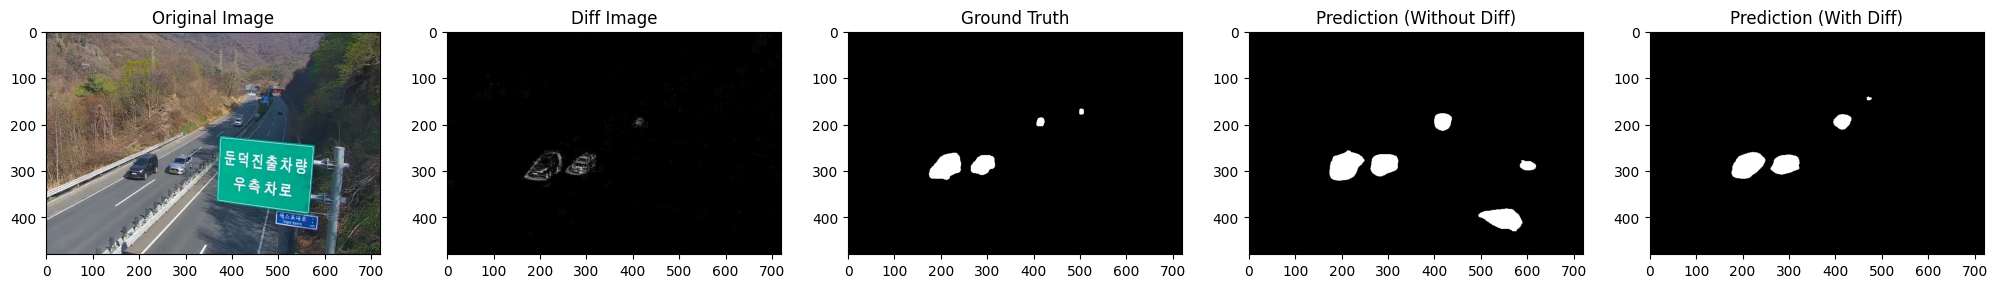

In [ ]:
random_idx = random.randint(0, len(test_dataset_without) - 1)
image_path = test_dataset_without.dataset.image_paths[test_dataset_without.indices[random_idx]]
mask_path = test_dataset_without.dataset.mask_paths[test_dataset_without.indices[random_idx]]
diff_path = test_dataset_without.dataset.diff_paths[test_dataset_without.indices[random_idx]]
visualize_prediction(image_path, mask_path, diff_path, model_without_diff, model_with_diff, feature_extractor)